In [1]:
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = "["
with open("../aminer_papers_4.txt") as myfile:
    counter = 0 
    for line in myfile:
        counter += 1
        data += line + ","
        if counter > 50000:
            break

data = data[:-1] + "]"

In [3]:
json_data = json.loads(data)

In [4]:
len(json_data)
json_data[0]

{'authors': [{'name': 'B. J. Hunt'}],
 'doi': '10.1191/096120300678828244',
 'id': '53e99addb7602d9702362bdd',
 'issue': '3',
 'lang': 'en',
 'n_citation': 5,
 'page_end': '193',
 'page_start': '189',
 'title': 'The endothelium in atherogenesis',
 'url': ['http://dx.doi.org/10.1191/096120300678828244'],
 'venue': 'Lupus',
 'volume': '9',
 'year': 2000}

In [5]:
paper_to_authors = dict()
paper_to_journal = dict()

for paper_obj in json_data:
    if 'id' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper = paper_obj['id']
        authors = paper_obj['authors']
        journal = paper_obj['venue']
        
        paper_to_authors[paper] = [author['name'] for author in authors]
        paper_to_journal[paper] = journal

In [6]:
len(paper_to_authors)

43153

In [7]:
author_to_author_and_papers = dict()

for paper_obj in json_data:
    if 'references' in paper_obj and 'authors' in paper_obj and 'venue' in paper_obj:
        paper_refs = paper_obj['references']
        author_and_papers = dict()
        for paper_ref in paper_refs:
            if paper_ref in paper_to_authors:
                authors = paper_to_authors[paper_ref]
                for author in authors:
                    if author not in author_and_papers:
                        author_and_papers[author] = [paper_ref]
                    else:
                        author_and_papers[author].append(paper_ref)
        for author in paper_obj['authors']:
            author_to_author_and_papers[author['name']] = author_and_papers

In [8]:
cleaned_author_to_etc = dict()

for obj in author_to_author_and_papers.keys():
    if author_to_author_and_papers[obj]:
        cleaned_author_to_etc[obj] = author_to_author_and_papers[obj]

In [9]:
# author_to_author_and_papers = cleaned_author_to_etc

In [10]:
len(author_to_author_and_papers)

28245

In [11]:
#returns id of author chosen uniformly randomly
def randStartPoint(author_to_score):
    idx = np.random.randint(len(author_to_score))
    return list(author_to_score.keys())[idx]   #perhaps sorting issues here? check later

def getScore(cur_author, proposed_author, author_to_score):
    papers = author_to_author_and_papers[cur_author][proposed_author]
    score = 0
    for paper in papers:
        paper_authors = paper_to_authors[paper]
        avg_author_score = np.mean([author_to_score[auth] for auth in paper_authors if auth in author_to_score])
        score += avg_author_score * paper_to_if[paper]
    
    return np.log10(score)
#     return 1

In [12]:
def graphtraversal(num_trials, num_walks_per_trial):
#     outputs = []
#     list_of_author_to_score = []
    numAuthors = len(author_to_author_and_papers)
    
    for i in range(num_trials):
        authors_explored = set()
        deadend = 0
        p_accept_lt_1 = 0
        trial_output = np.zeros((numAuthors, num_walks_per_trial))
        
        startScore = 1
        author_to_score = collections.OrderedDict([(author, startScore) for author in author_to_author_and_papers.keys()])
        
        print("Trial number ", str(i+1), "/", num_trials)
    
        #select uniform start point
        cur_author = randStartPoint(author_to_score)
        authors_explored.add(cur_author)
        
        for num_walk in range(num_walks_per_trial):
            if len(author_to_author_and_papers[cur_author]) == 0: #current author is a dead end
                cur_author = randStartPoint(author_to_score)
                authors_explored.add(cur_author)
                deadend += 1
            else:
                tries = 10
                for t in range(tries):
                    idx = np.random.randint(len(author_to_author_and_papers[cur_author]))
                    proposed_author = list(author_to_author_and_papers[cur_author].keys())[idx]
                    if proposed_author in author_to_score:
                        break
                if proposed_author not in author_to_score:
                    cur_author = randStartPoint(author_to_score)
                    authors_explored.add(cur_author)
                    continue

                #accept or not? according to metropolis hastings 
                pi_y = author_to_score[proposed_author]  #pi(x) = score(x)
                pi_x = author_to_score[cur_author]
                
                # Proposal function f(x) = 1/d where d is degree of node x (number of outgoing edges)
                f_y = 1 / max(1, len(author_to_author_and_papers[proposed_author]))
                f_x = 1 / max(1, len(author_to_author_and_papers[cur_author]))
                
#                 print("pi_y: ", str(pi_y))
#                 print("pi_x: ", str(pi_x))
#                 print("f_y: ", str(f_y))
#                 print("f_x: ", str(f_x))
#                 print("p_accept: ", (pi_y * f_y) / (pi_x * f_x))
                p_accept = min(1, (pi_y * f_y) / (pi_x * f_x))
                if p_accept < 1:
                    p_accept_lt_1 += 1

                if proposed_author in author_to_score and np.random.random() < p_accept and proposed_author != cur_author:
                    #if accept, update proposed_author's score.  Then move to proposed_author
                    author_to_score[proposed_author] += getScore(cur_author, proposed_author, author_to_score)
                    cur_author = proposed_author
                    authors_explored.add(cur_author)
                    
#                     print("printing all scores before norm...")
#                     for author, score in zip(author_to_score.keys(), author_to_score.values()):
#                         print("author: ", author)
#                         print("score: ", score)

                    #renormalize everyone author's score
#                     norm_score = sum(author_to_score.values())
#                     norm_score = max(author_to_score.values())

#                     print("printing all scores...")
#                     for author in author_to_score:
#                         author_to_score[author] = author_to_score[author] / norm_score
#                         print("author: ", author)
#                         print("score: ", author_to_score[author])

                else:  #if not accept, randomly start again
                    cur_author = randStartPoint(author_to_score)
                    authors_explored.add(cur_author)
            trial_output[:, num_walk] = list(author_to_score.values())
        
        #add trial results to output matrix
#         outputs.append(trial_output)
#         list_of_author_to_score.append(author_to_score)
        print("# authors explored: ", len(authors_explored), " | # total authors: ", len(author_to_score))
        print("# of deadends: ", deadend, " | # of p_accept < 1: ", p_accept_lt_1)
        print('\n')
        
        #plot and display results
        top_authors = sorted(author_to_score, key=author_to_score.get, reverse=True)[:10]
        top_authors_idx = [list(author_to_score.keys()).index(author) for author in top_authors]
        print(top_authors)

        plt.figure()
        rows, cols = trial_output.shape
        first = True
        for row in top_authors_idx:
            if first:
                first = False
                continue
            y_data = trial_output[row]
            plt.plot(range(cols), y_data, '.')
     
#     return outputs, list_of_author_to_score

Trial number  1 / 5
# authors explored:  18338  | # total authors:  28245
# of deadends:  28474  | # of p_accept < 1:  200


['R. Axelrod', 'James Gosling', 'Guy L. Steele', 'Lawrence A. Rowe', 'H. Young', 'A. H. Clifford', 'DEWEY C. SCHEID', 'Alberto Carlini', 'Vincent S.E. Falger', 'J. Christensen-Dalsgaard']
Trial number  2 / 5
# authors explored:  18375  | # total authors:  28245
# of deadends:  28482  | # of p_accept < 1:  207


['Robert Endre Tarjan', 'R. Axelrod', 'Mitchel Resnick', 'Guy L. Steele', 'V. S. Subrahmanian', 'Rosalba Giugno', 'Giinter Schmahl', 'H. Young', 'J. Christensen-Dalsgaard', 'C. J. Howe']
Trial number  3 / 5
# authors explored:  18380  | # total authors:  28245
# of deadends:  28517  | # of p_accept < 1:  194


['R. Axelrod', 'Guy L. Steele', 'Mitchel Resnick', 'James Gosling', 'Jeffrey I. Zink', 'Yosuke Okudaira', 'H. Young', 'H. Hansmann', 'Miquel Vilafranca', 'Tatsuhiko Koike']
Trial number  4 / 5
# authors explored:  18319  | # total authors:  28245
# o

MemoryError: 

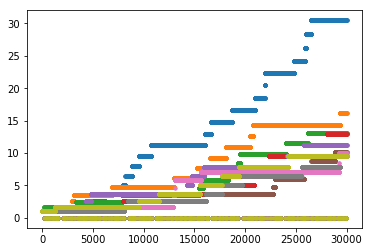

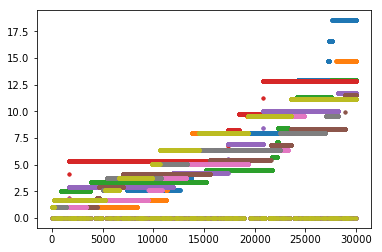

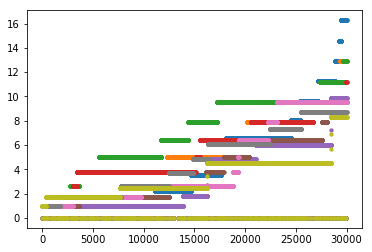

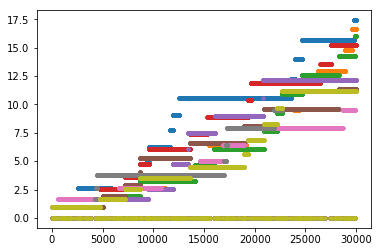

In [13]:
value = 5
paper_to_if = {key:value for key in paper_to_journal.keys()}
# outputs, list_of_author_to_score = graphtraversal(5, 30000)
graphtraversal(5, 30000)

In [ ]:
for output, author_to_score in zip(outputs, list_of_author_to_score):
    top_authors = sorted(author_to_score, key=author_to_score.get, reverse=True)[:10]
    top_authors_idx = [list(author_to_score.keys()).index(author) for author in top_authors]
    print(top_authors)
    
    plt.figure()
    rows, cols = output.shape
    first = True
    for row in top_authors_idx:
        if first:
            first = False
            continue
        y_data = output[row]
        plt.plot(range(cols), y_data, '.')

In [ ]:
unique, counts = np.unique(list(paper_to_journal.values()), return_counts = True)
journal_occurences = dict(zip(unique, counts))